In [1]:
import numpy as np
from matplotlib import pyplot as plt
import random
from scipy.sparse.linalg import svds
import sys
import time

## Generowanie macierzy

In [2]:
def generate_grid_adjacency_matrix(k):
    n = 2 ** k
    total_vertices = n ** 3 

    adjacency_matrix = np.zeros((total_vertices, total_vertices))

    def linear_index(x, y, z):
        return x * n * n + y * n + z

    for x in range(n):
        for y in range(n):
            for z in range(n):
                current = linear_index(x, y, z)

                neighbors = []
                if x > 0:
                    neighbors.append(linear_index(x - 1, y, z))
                if x < n - 1:
                    neighbors.append(linear_index(x + 1, y, z))
                if y > 0:
                    neighbors.append(linear_index(x, y - 1, z))
                if y < n - 1:
                    neighbors.append(linear_index(x, y + 1, z))
                if z > 0:
                    neighbors.append(linear_index(x, y, z - 1))
                if z < n - 1:
                    neighbors.append(linear_index(x, y, z + 1))

                for neighbor in neighbors:
                    adjacency_matrix[current, neighbor] = random.uniform(1, 300)

    return adjacency_matrix



Kompresja z poprzedniego lab

In [3]:
class Node:
    def __init__(self, rank = None, sing_val = None, U = None, V = None, size_ = None):
        self.rank, self.sing_val, self.U, self.V, self.size_ = rank, sing_val, U, V, size_
        self.sons = []

def CompressMatrix(A, t_min, t_max, s_min, s_max, U, D, V, r):
    selected_matrix = A[t_min:t_max+1, s_min:s_max+1]
    if( np.allclose(selected_matrix, np.zeros_like(selected_matrix))) :
        v = Node(0, np.array([]), np.array([]), np.array([]), (t_min, t_max, s_min, s_max) )
        return v
    sigma_ = np.diag(D)
    u = Node()
    u.rank = r
    u.sing_val = sigma_[:u.rank]
    u.U = U[:, :u.rank]
    u.V = np.matmul(D[:u.rank, :u.rank], V[:u.rank, :])
    u.size_ = (t_min, t_max, s_min, s_max)
    return u

def CreateTree(A, t_min, t_max, s_min, s_max, r, epsi):
    if t_max-t_min<=r+1 or s_max - s_min <= r+1:
        U, D, V = np.linalg.svd(A[t_min:t_max+1, s_min:s_max+1])
    else:
       U, D, V = svds(A[t_min:t_max+1, s_min:s_max+1], k=r+1)
       U = U[:, ::-1]
       D = D[::-1]
       V =V[::-1, :]
    D_new = np.zeros((D.shape[0], D.shape[0]))
    np.fill_diagonal(D_new, D)
    if (t_max - t_min <= r + 1 or s_max - s_min <= r + 1 or D_new[r,r] < epsi):
        v = CompressMatrix(A, t_min, t_max, s_min, s_max, U, D_new, V, r)
        return v
    v = Node()
    t_newmax = (t_min + t_max)//2
    s_newmax = (s_min + s_max)//2
    v.sons.append(CreateTree(A, t_min, t_newmax, s_min, s_newmax, r, epsi))
    v.sons.append(CreateTree(A, t_min, t_newmax, s_newmax+1, s_max, r, epsi))
    v.sons.append(CreateTree(A, t_newmax+1, t_max, s_min, s_newmax, r, epsi))
    v.sons.append(CreateTree(A, t_newmax+1, t_max, s_newmax + 1, s_max, r, epsi))
    return v

def CreateTree(A, t_min, t_max, s_min, s_max, r, epsi):
    U, D, V = np.linalg.svd(A[t_min:t_max+1, s_min:s_max+1])
    D_new = np.zeros((D.shape[0], D.shape[0]))
    np.fill_diagonal(D_new, D)
    if(r+1 >= D_new.shape[0] or r+1 >= D_new.shape[1] or D_new[r+1, r+1] < epsi):
        v = CompressMatrix(A, t_min, t_max, s_min, s_max, U, D_new, V, r)
        return v
    v = Node()
    t_newmax = (t_min + t_max)//2
    s_newmax = (s_min + s_max)//2
    v.sons.append(CreateTree(A, t_min, t_newmax, s_min, s_newmax, r, epsi))
    v.sons.append(CreateTree(A, t_min, t_newmax, s_newmax+1, s_max, r, epsi))
    v.sons.append(CreateTree(A, t_newmax+1, t_max, s_min, s_newmax, r, epsi))
    v.sons.append(CreateTree(A, t_newmax+1, t_max, s_newmax + 1, s_max, r, epsi))
    return v

In [4]:
def draw_compression_matrix(u,M,t_min, t_max, s_min, s_max):
    if len(u.sons)==0:
        M[t_min:t_min+u.rank, s_min:s_max+1] = 0
        M[t_min:t_max+1, s_min:s_min+u.rank] = 0
    else:
        t_newmax = (t_min + t_max)//2
        s_newmax = (s_min + s_max)//2
        draw_compression_matrix(u.sons[0], M, t_min, t_newmax, s_min, s_newmax)
        draw_compression_matrix(u.sons[1], M, t_min, t_newmax, s_newmax+1, s_max)
        draw_compression_matrix(u.sons[2], M, t_newmax+1, t_max, s_min, s_newmax)
        draw_compression_matrix(u.sons[3], M, t_newmax+1, t_max, s_newmax + 1, s_max)

def reconstruct_matrix(u, M, t_min, t_max, s_min, s_max):
    if len(u.sons)==0:
        if u.rank != 0:
            M_reconstructed = np.matmul(u.U, u.V)
            M[t_min:t_max+1, s_min:s_max+1] = M_reconstructed
    else:
        t_newmax = (t_min + t_max)//2
        s_newmax = (s_min + s_max)//2
        reconstruct_matrix(u.sons[0], M, t_min, t_newmax, s_min, s_newmax)
        reconstruct_matrix(u.sons[1], M, t_min, t_newmax, s_newmax+1, s_max)
        reconstruct_matrix(u.sons[2], M, t_newmax+1, t_max, s_min, s_newmax)
        reconstruct_matrix(u.sons[3], M, t_newmax+1, t_max, s_newmax + 1, s_max)

def compression(A,r,eps):
    tree = CreateTree(A.astype(float), 0, A.shape[0]-1, 0, A.shape[1]-1, r, eps)
    A_compressed = np.ones_like(A)
    draw_compression_matrix(tree, A_compressed, 0, A.shape[0]-1, 0, A.shape[1]-1)
    A_reconstructed = np.zeros_like(A)
    reconstruct_matrix(tree, A_reconstructed, 0, A.shape[0]-1, 0, A.shape[1]-1)
    return A_compressed, A_reconstructed

## Mnożenie macierzy przez wektor

In [5]:
def matrix_vector_mult(v, X):
    if not v.sons:
        if v.rank == 0:
            return np.zeros(len(X))
        return np.matmul(v.U, np.matmul(v.V, X))
    rows = len(X)
    X1 = X[: rows // 2]
    X2 = X[rows // 2 :]
    Y11 = matrix_vector_mult(v.sons[0], X1)
    Y12 = matrix_vector_mult(v.sons[1], X2)
    Y21 = matrix_vector_mult(v.sons[2], X1)
    Y22 = matrix_vector_mult(v.sons[3], X2)
    return np.hstack((np.add(Y11,Y12),np.add(Y21,Y22)))

Wyniki i wykresy

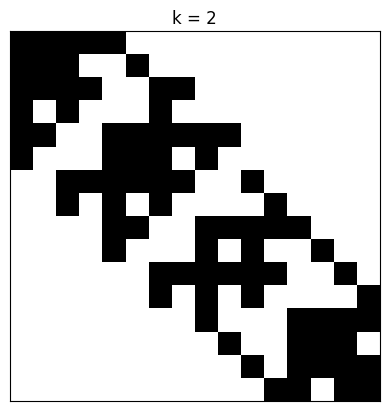

Norma Frobeniusa dla k = 2: 1.6584971281688205e-21


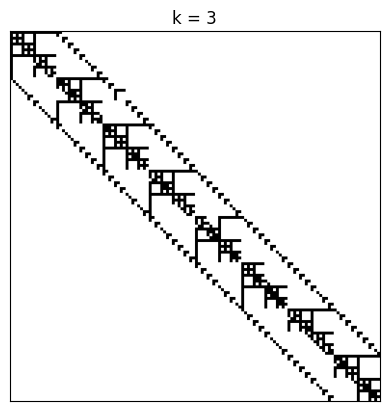

Norma Frobeniusa dla k = 3: 8.412272187683319e-21


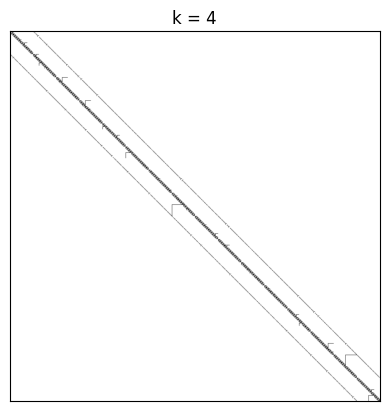

Norma Frobeniusa dla k = 4: 7.189582647425975e-20


In [ ]:
r = 4
matrix_vector_mult_times =[]
K = [2, 3, 4]
for k in K:
    # kompresja macierzy
    A = generate_grid_adjacency_matrix(k)
    _, D, _ = np.linalg.svd(A)
    v = CreateTree(A.astype(float), 0, A.shape[0]-1, 0, A.shape[1]-1, r, D[len(D) * 3 // 4])
    A_compressed = np.ones_like(A)
    draw_compression_matrix(v, A_compressed, 0, A.shape[0]-1, 0, A.shape[1]-1)
    plt.imshow(A_compressed, cmap="gray")
    plt.xticks([]), plt.yticks([])
    plt.title(f"k = {k}")
    plt.show()

    # pomiar czasu
    start_time = time.time()

    X = np.random.uniform(1, 100, (2 ** 3) ** k)
    result = matrix_vector_mult(v, X)
    matrix_vector_mult_times.append(time.time() - start_time)

    # porównanie wyników
    A_reconstructed = np.zeros_like(A)
    reconstruct_matrix(v, A_reconstructed, 0, A.shape[0]-1, 0, A.shape[1]-1)
    result_after_decompression = np.matmul(A_reconstructed,X)

    differences = result_after_decompression - result
    squared_differences = differences ** 2
    print(f"Norma Frobeniusa dla k = {k}:",np.sum(squared_differences))



    

0.4012806085655883 0.0007403927883514233
Dopasowane wartości: alfa = 0.4013, beta = 0.0007


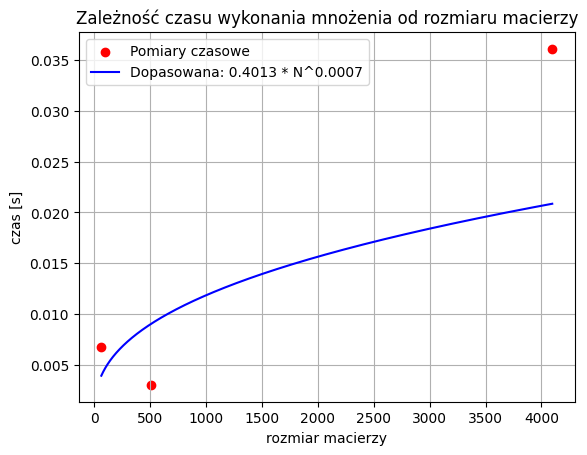

In [ ]:

times_arr  = np.array(matrix_vector_mult_times)

#times = [t*100 for t in times_arr]
#print(times)

sizes = [(2**3)**k for k in K]
log_sizes = np.log(np.array(sizes))
log_times = np.log(times_arr)
alpha, beta = np.polyfit(log_sizes, log_times, 1)
beta = np.exp(beta)
print(alpha, beta)
print(f"Dopasowane wartości: alfa = {alpha:.4f}, beta = {beta:.4f}")

N_fit = np.linspace(min(sizes), max(sizes), 1000)
y_fit = [ N**alpha * beta for N in N_fit]

#N_fit = np.linspace(min(log_sizes), max(log_sizes), 1000)
#y_fit = [ N*alpha + beta for N in N_fit]

plt.scatter(sizes, times_arr, color='red', label='Pomiary czasowe')
plt.plot(N_fit, y_fit, color='blue', label=f'Dopasowana: {alpha:.4f} * N^{beta:.4f}')
plt.xlabel('rozmiar macierzy')
plt.ylabel('czas [s]')
plt.legend()
plt.title('Zależność czasu wykonania mnożenia od rozmiaru macierzy')
plt.grid()

## Mnożenie macierzy skompresowanych

In [49]:
def rSVDofCompressed(v,w):
    U = np.hstack((v.U,w.U))
    V = np.vstack((v.V,w.V))
    M = np.matmul(U,V)
    return CreateTree(M, 0, M.shape[0]-1, 0, M.shape[1]-1, r, eps)

def create_subnode(v, U_slice, V_slice):
    u = Node()

    u.rank = v.rank
    u.U = v.U[U_slice, :]
    u.V = v.V[:, V_slice]
    u.sons = []
    return u
    

def matrix_matrix_add(v, w):
    if not v.sons and not w.sons:
        if v.rank == 0 and w.rank == 0:
            res = Node(0)
            return res
        if v.rank != 0 and w.rank != 0:
            return rSVDofCompressed(v,w)
    if v.rank != 0 and w.rank == 0:
        return v
    if v.rank == 0 and w.rank != 0:
        return w
    if v.sons and w.sons:
        res = Node()
        res.sons.append(matrix_matrix_add(v.sons[0],w.sons[0]))
        res.sons.append(matrix_matrix_add(v.sons[1],w.sons[1]))
        res.sons.append(matrix_matrix_add(v.sons[2],w.sons[2]))
        res.sons.append(matrix_matrix_add(v.sons[3],w.sons[3]))
        return res
    if not v.sons and w.sons:
        half = len(v.U) // 2
        u11 = create_subnode(v, slice(0, half), slice(0, half))
        u12 = create_subnode(v, slice(0, half), slice(half, None))
        u21 = create_subnode(v, slice(half, None), slice(0, half))
        u22 = create_subnode(v, slice(half, None), slice(half, None))
        res = Node()
        res.sons.append(matrix_matrix_add(u11, w.sons[0]))
        res.sons.append(matrix_matrix_add(u12, w.sons[1]))
        res.sons.append(matrix_matrix_add(u21, w.sons[2]))
        res.sons.append(matrix_matrix_add(u22, w.sons[3]))
        return res
    if v.sons and not w.sons:
        half = len(w.U) // 2
        u11 = create_subnode(w, slice(0, half), slice(0, half))
        u12 = create_subnode(w, slice(0, half), slice(half, None))
        u21 = create_subnode(w, slice(half, None), slice(0, half))
        u22 = create_subnode(w, slice(half, None), slice(half, None))
        res = Node()
        res.sons.append(matrix_matrix_add(v.sons[0], u11))
        res.sons.append(matrix_matrix_add(v.sons[1], u12))
        res.sons.append(matrix_matrix_add(v.sons[2], u21))
        res.sons.append(matrix_matrix_add(v.sons[3], u22))
        return res

In [51]:
def matrix_matrix_mult(v, w):
    if not v.sons and not w.sons:
        if v.rank == 0 and w.rank == 0:
            res = Node(0)
            return res
        if v.rank != 0 and w.rank != 0:
            res = Node(v.rank)
            res.U = np.matmul(v.U,(np.matmul(v.V, w.U)))
            res.V = w.V
            return res
    if v.rank != 0 and w.rank == 0:
        return w
    if v.rank == 0 and w.rank != 0:
        return v
    if v.sons and w.sons:
        res = Node()
        res.sons.append(matrix_matrix_add(matrix_matrix_mult(v.sons[0],w.sons[0]),matrix_matrix_mult(v.sons[1],w.sons[2])))
        res.sons.append(matrix_matrix_add(matrix_matrix_mult(v.sons[0],w.sons[1]),matrix_matrix_mult(v.sons[1],w.sons[3])))
        res.sons.append(matrix_matrix_add(matrix_matrix_mult(v.sons[2],w.sons[0]),matrix_matrix_mult(v.sons[3],w.sons[2])))
        res.sons.append(matrix_matrix_add(matrix_matrix_mult(v.sons[2],w.sons[1]),matrix_matrix_mult(v.sons[3],w.sons[3])))
        return res
    if not v.sons and w.sons:
        half = len(v.U) // 2
        u11 = create_subnode(v, slice(0, half), slice(0, half))
        u12 = create_subnode(v, slice(0, half), slice(half, None))
        u21 = create_subnode(v, slice(half, None), slice(0, half))
        u22 = create_subnode(v, slice(half, None), slice(half, None))
        res = Node()
        res.sons.append(matrix_matrix_add(matrix_matrix_mult(u11,w.sons[0]),matrix_matrix_mult(u12,w.sons[2])))
        res.sons.append(matrix_matrix_add(matrix_matrix_mult(u11,w.sons[1]),matrix_matrix_mult(u12,w.sons[3])))
        res.sons.append(matrix_matrix_add(matrix_matrix_mult(u21,w.sons[0]),matrix_matrix_mult(u22,w.sons[2])))
        res.sons.append(matrix_matrix_add(matrix_matrix_mult(u21,w.sons[1]),matrix_matrix_mult(u22,w.sons[3])))
        return res
    if v.sons and not w.sons:
        half = len(w.U) // 2
        u11 = create_subnode(w, slice(0, half), slice(0, half))
        u12 = create_subnode(w, slice(0, half), slice(half, None))
        u21 = create_subnode(w, slice(half, None), slice(0, half))
        u22 = create_subnode(w, slice(half, None), slice(half, None))
        res = Node()
        res.sons.append(matrix_matrix_add(matrix_matrix_mult(v.sons[0], u11),matrix_matrix_mult(v.sons[1], u21)))
        res.sons.append(matrix_matrix_add(matrix_matrix_mult(v.sons[0], u12),matrix_matrix_mult(v.sons[1], u22)))
        res.sons.append(matrix_matrix_add(matrix_matrix_mult(v.sons[2], u11),matrix_matrix_mult(v.sons[3], u21)))
        res.sons.append(matrix_matrix_add(matrix_matrix_mult(v.sons[2], u12),matrix_matrix_mult(v.sons[3], u22)))
        return res

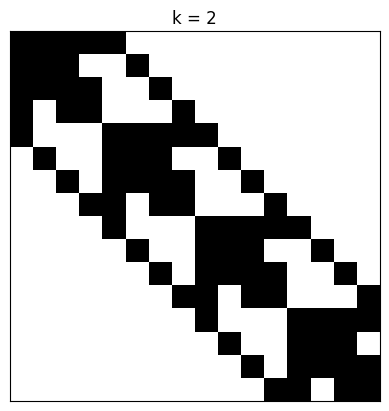

Norma Frobeniusa dla k = 2: 1.895522915352223e-18


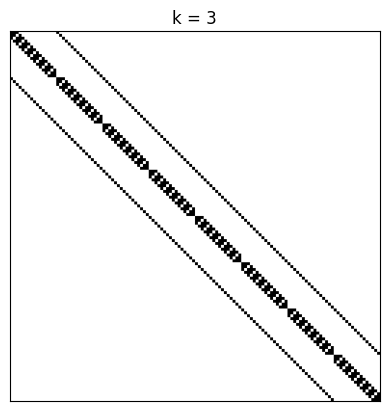

Norma Frobeniusa dla k = 3: 1.5691523175943385e-17


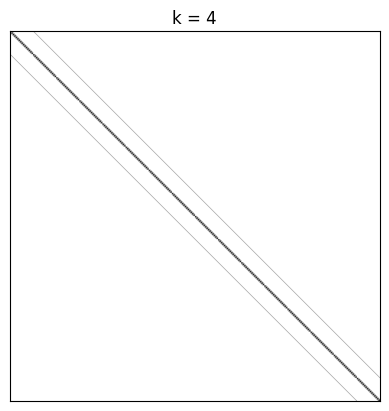

Norma Frobeniusa dla k = 4: 1.3340007931660849e-16


In [53]:
r = 4
matrix_matrix_mult_times =[]
K = [2, 3, 4]
for k in K:
    # kompresja macierzy
    A = generate_grid_adjacency_matrix(k)
    _, D, _ = np.linalg.svd(A)
    eps = D[-1]
    v = CreateTree(A.astype(float), 0, A.shape[0]-1, 0, A.shape[1]-1, r, eps)
    A_compressed = np.ones_like(A)
    draw_compression_matrix(v, A_compressed, 0, A.shape[0]-1, 0, A.shape[1]-1)
    plt.imshow(A_compressed, cmap="gray")
    plt.xticks([]), plt.yticks([])
    plt.title(f"k = {k}")
    plt.show()

    # pomiar czasu
    start_time = time.time()

    result = matrix_matrix_mult(v, v)
    result_reconstructed = np.zeros_like(A)
    reconstruct_matrix(result, result_reconstructed, 0, A.shape[0]-1, 0, A.shape[1]-1)
    matrix_matrix_mult_times.append(time.time() - start_time)

    # porównanie wyników
    A_reconstructed = np.zeros_like(A)
    reconstruct_matrix(v, A_reconstructed, 0, A.shape[0]-1, 0, A.shape[1]-1)
    result_after_decompression = np.matmul(A_reconstructed,A_reconstructed)


    differences = result_after_decompression - result_reconstructed
    squared_differences = differences ** 2
    print(f"Norma Frobeniusa dla k = {k}:",np.sum(squared_differences))





1.0691707405531943 0.00038305290163878847
Dopasowane wartości: alfa = 1.0692, beta = 0.0004


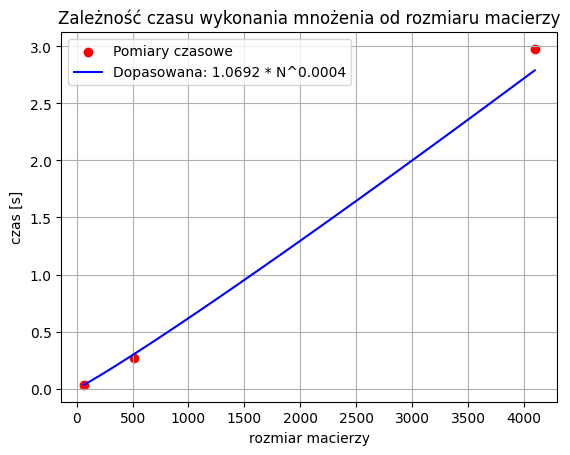

In [55]:
sizes = [(2**3)**k for k in K]
log_sizes = np.log(np.array(sizes))
log_times_mat = np.log(matrix_matrix_mult_times)
alpha, beta = np.polyfit(log_sizes, log_times_mat, 1)
beta = np.exp(beta)
print(alpha, beta)
print(f"Dopasowane wartości: alfa = {alpha:.4f}, beta = {beta:.4f}")

N_fit = np.linspace(min(sizes), max(sizes), 1000)
y_fit = [ N**alpha * beta for N in N_fit]

#N_fit = np.linspace(min(log_sizes), max(log_sizes), 1000)
#y_fit = [ N*alpha + beta for N in N_fit]

plt.scatter(sizes, matrix_matrix_mult_times, color='red', label='Pomiary czasowe')
plt.plot(N_fit, y_fit, color='blue', label=f'Dopasowana: {alpha:.4f} * N^{beta:.4f}')
plt.xlabel('rozmiar macierzy')
plt.ylabel('czas [s]')
plt.legend()
plt.title('Zależność czasu wykonania mnożenia od rozmiaru macierzy')
plt.grid()